# Hard Disk Drive (HDD) survival analysis in python

## Part II: Non-parametric estimators (Kaplan-Meier)

Date: March 2018

Autor: [Alvaro Calle Cordon](www.linkedin.com/in/alvarocallecordon)

Notebook uses Python 2.7

## Descripción del notebook

In the previous notebook `HDD_survival_I_Preparation` we found and prepared some interesting real-world data suited for a survival analysis: the records of activity and failures for >40,000 harddrives, open-sourced and made freely available in Feb 2015 by BackBlaze, an online file backup and storage company.

In this notebook we will firstly explore the data further, and then run `Kaplan-Meier` modelling to understand the survival rates for the harddrives.

## Documentación

- https://github.com/MustafaOguz/Survival_Analysis
- https://github.com/search?l=Python&q=survival+analysis&type=Repositories&utf8=%E2%9C%93
- https://github.com/eduardoleon/survival
- https://github.com/jaredleekatzman/DeepSurv
- https://github.com/CamDavidsonPilon/lifelines
- http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html
- http://blog.applied.ai/survival-analysis-part2

## Setup

### Initial setups

In [1]:
# plots in the notebook
%matplotlib inline

# fire ipython console
#%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

### Libraries

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sqlite3

from collections import OrderedDict
import lifelines as sa

### Customizations

In [3]:
# set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

np.random.seed(0)   

# set font format
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 12}

## Loading the data

We load here the table `drive_survival_prepared` generated in the previous notebook `HDD_survival_I_Preparation` which has been stored in the sqlitle database `drive_stats.db`.

In [4]:
# Where am I?
%pwd

u'/home/alvaro/Documentos/Analytics/Survival'

In [5]:
# check drive_stats.db is in the current directory
%ls

data_Q3_2016/      drive_stats.db            HDD_survival_I_Preparation.ipynb
data_Q3_2016.zip   drive_survival.sql        survival_r_vs_python.ipynb
docs_Q3_2016/      drive_survival.sql~       temp-plot.html
docs_Q3_2016+.zip  HDD_survival_II_KM.ipynb


**SQL connector** 

In [6]:
cnx = sqlite3.connect('drive_stats.db')
csr = cnx.cursor()

**Check tables in database**

In [7]:
csr.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(csr.fetchall())

[(u'drive_stats',), (u'drive_survival',), (u'drive_survival_prepared',)]


**Pre-processed data from sqlitle db**

In [8]:
query = 'select * from drive_survival_prepared'
df = pd.read_sql(query, con=cnx, index_col='diskid', parse_dates=['mindate','maxdate'])

In [9]:
print df.shape

(67340, 11)


In [10]:
df.head()

,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW00J2Z,ST31500541AS,2016-07-21,2016-09-30,62,46815,48301,0,SEAGATE,1.5TB,201607,201609
5XW029ZZ,ST31500541AS,2016-07-21,2016-09-30,62,50682,52168,0,SEAGATE,1.5TB,201607,201609
5XW02BHJ,ST31500541AS,2016-07-21,2016-09-30,62,45703,47362,0,SEAGATE,1.5TB,201607,201609
5XW02L6V,ST31500541AS,2016-07-21,2016-09-30,62,54121,55780,0,SEAGATE,1.5TB,201607,201609
5XW02N56,ST31500541AS,2016-07-21,2016-09-30,62,50686,52172,0,SEAGATE,1.5TB,201607,201609


## Simple Counts

### Counts by manufacturer and capacity in use

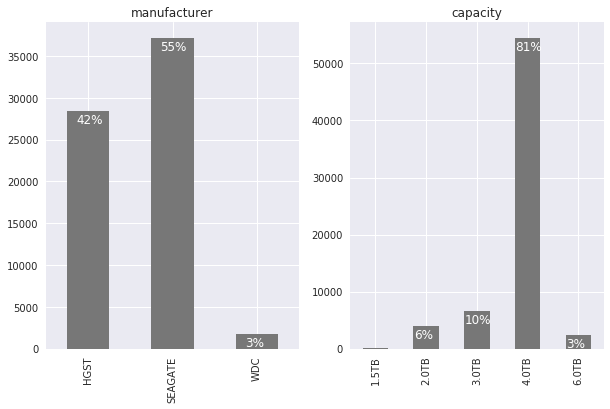

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

for j, feature in enumerate(['manufacturer', 'capacity']):
    
    gp = df.groupby([feature]).size()
    ax = gp.plot(kind='bar', ax=axes[0,j], title=feature)
    ax.set_xlabel("")
    for k, p in enumerate(gp):
        axes[0,j].annotate('{:.0%}'.format(p/float(gp.sum())), xy=(k,p), xycoords='data', xytext=(-12,-12),
                           textcoords='offset points', color='w',fontsize=12)

**Observation**: HGST and Seagate drives are represented in approximatelly similar total amounts, with WDC in the great minority

> The most popular capacity drive is 4TB, with 3TB drives making up most of the remainder

### Drives by Manufacturer and by Capacity (cross information)

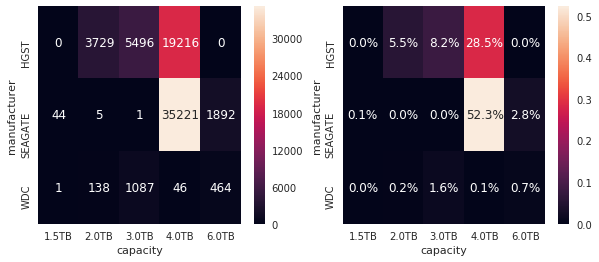

In [12]:
gp = df.groupby(['manufacturer','capacity']).size().unstack()
gp[pd.isnull(gp)] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), squeeze=False, sharex=True, sharey=True)
ax = sns.heatmap(gp, annot=True, fmt='.0f', ax=axes[0,0])
ax = sns.heatmap(gp/gp.sum().sum(), annot=True, fmt='.1%', ax=axes[0,1])

**Observation**:

- Seagate and HGST are similarly matched for counts, and also represented similarly for capacities with each of their 4TB drive classes accounting for ~28% of the total.
- Some imbalances become clear:
    - The overwhelming majority of 2 TB drives belong to HGST, and the 1.5TB drives are mostly Seagate.
    - WDC is most often seen in the 3TB category, and HGST AND SEAGATE in the 4TB.



## Simple distributions and ratios
### Drive failures by age

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd61618cc10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd615da53d0>], dtype=object)

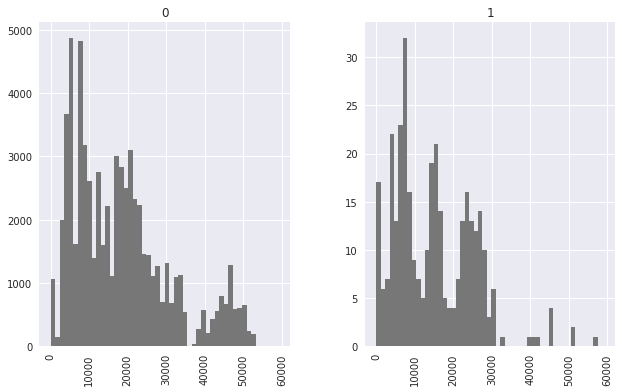

In [13]:
df.hist(column='maxhours', by=['failed'], bins=50, sharex=True)

**Observation**:

- A dropoff in number of drives with increasing age, as you would expect for a survival analysis.
- Three noticable failure peaks in drive failures around the 10,000, 20,000 and 30,000 hour mark
- In fact the distribution of failures with time looks quite multi-modal, likely to be different group of failures in the data.

### Drive failures by age by manufacturer

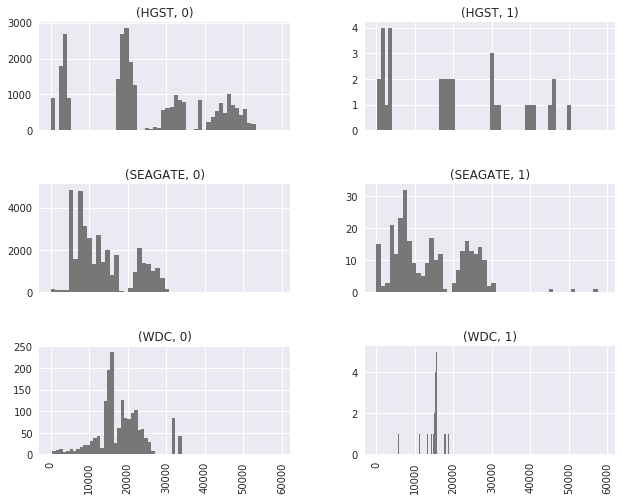

In [14]:
ax = df.hist(column='maxhours', by=['manufacturer','failed'], bins=50, sharex=True, figsize=(10,8))

**Observation**:

- Seagate drives show two clear peaks
- HGST appears quite 'lumpy' - possibly drives were bought and installed in well-defined batches
- WDC has not been used for very long - only has values up to 20,000 hours

### Drive failures by manufacturer and capacity

In [15]:
gp = df.groupby(['manufacturer','capacity','failed']).size().unstack()

gp['prop'] = gp[1] / gp.sum(axis=1) # proportion of failures wrt total
gp.reset_index(inplace=True)
gp.rename(columns={0:'active', 1:'failure'}, inplace=True)
gp

failed,manufacturer,capacity,active,failure,prop
0,HGST,2.0TB,3726.0,3.0,0.000805
1,HGST,3.0TB,5489.0,7.0,0.001274
2,HGST,4.0TB,19195.0,21.0,0.001093
3,SEAGATE,1.5TB,41.0,3.0,0.068182
4,SEAGATE,2.0TB,5.0,NaN,NaN
5,SEAGATE,3.0TB,1.0,NaN,NaN
6,SEAGATE,4.0TB,34938.0,283.0,0.008035
7,SEAGATE,6.0TB,1889.0,3.0,0.001586
8,WDC,1.5TB,1.0,NaN,NaN
9,WDC,2.0TB,138.0,NaN,NaN


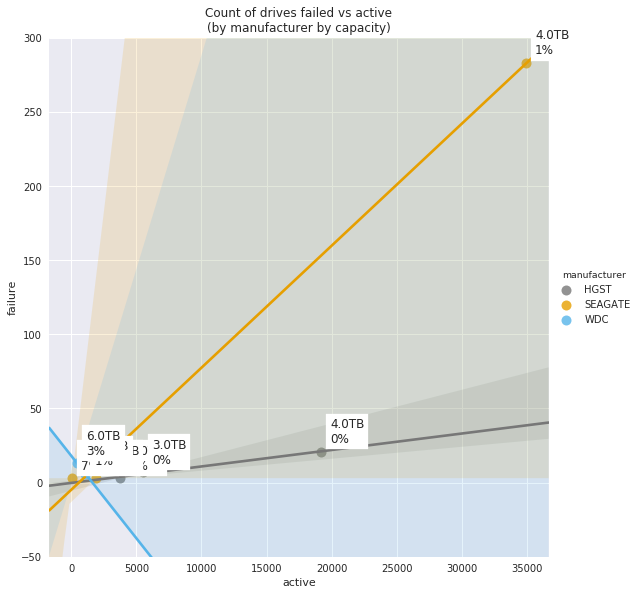

In [16]:
data=gp.dropna()

ax = sns.lmplot(data=data, x='active', y='failure', hue='manufacturer', size=8, fit_reg=True, scatter_kws={'s':100})
plt.title('Count of drives failed vs active\n(by manufacturer by capacity)')
ax.axes[0, 0].set_ylim(-50, 300)

for i, r in data.iterrows():
    plt.annotate(s='{}\n{:.0%}'.format(r[1],r[4]), xy=(r[2],r[3]), xycoords='data',
                 xytext=(9,9), textcoords=('offset points'), axes = ax.axes[0, 0], backgroundcolor='w')

## Kaplan-Meier Modeling

We now apply a non-parametric estimation of the survival function. This model gives us a maximum-likelihood estimate of the survival function of the form:

$$
\hat S(t) = \prod\limits_{t_i \\< t} \frac{n_i - d_i}{n_i}
$$

where $d$ and $n$ are respectively the count of 'death' events and individuals at risk at timestep $i$.

The cumulative product gives us a non-increasing curve where we can read off, at any timestep during the study, the estimated probability of survival from the start to that timestep. We can also compute the estimated survival time or median survival time (halflife).

Lets apply the Kaplan-Meier model to our harddrive failure data, at an overall level and also look at subsets by manufacturer and capacity.

In [17]:
df.head()

,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW00J2Z,ST31500541AS,2016-07-21,2016-09-30,62,46815,48301,0,SEAGATE,1.5TB,201607,201609
5XW029ZZ,ST31500541AS,2016-07-21,2016-09-30,62,50682,52168,0,SEAGATE,1.5TB,201607,201609
5XW02BHJ,ST31500541AS,2016-07-21,2016-09-30,62,45703,47362,0,SEAGATE,1.5TB,201607,201609
5XW02L6V,ST31500541AS,2016-07-21,2016-09-30,62,54121,55780,0,SEAGATE,1.5TB,201607,201609
5XW02N56,ST31500541AS,2016-07-21,2016-09-30,62,50686,52172,0,SEAGATE,1.5TB,201607,201609


In [18]:
def plot_km(km, axes, suptxt='', subtxt='', i=0, j=0, arws=[], xmax=0, smlfs=10):
    """
    This function plots the survival function given by the KM estimator
    """

    ax = km.plot(ax=axes[i,j], title=subtxt, legend=False)
    plt.suptitle(suptxt, fontsize=14)
    axes[i,j].axhline(0.5, ls='--', lw=0.5)
    axes[i,j].annotate('half-life', fontsize=smlfs, color='b',
                       xy=(0,0.5), xycoords='axes fraction',
                       xytext=(10,4), textcoords='offset points')

    S = km.survival_function_
    hl = S.loc[S['KM_estimate']<0.5,'KM_estimate'].head(1)
    if len(hl) == 1:
        axes[i,j].annotate('{:.0f}'.format(hl.index[0]), fontsize=smlfs,
                           xy=(0,0.5), xycoords='axes fraction',
                           xytext=(10,-12), textcoords='offset points', color='b')

    for pt in arws:
        tml = km.survival_function_[:pt].tail(1)
        plt.annotate('{:.1%}\n@ {:.0f}hrs'.format(tml['KM_estimate'].values[0],tml.index.values[0]),
                     xy=(tml.index.values,tml['KM_estimate'].values), xycoords='data',
                     xytext=(6,-50), textcoords='offset points', color='#007777', fontsize=smlfs,
                     arrowprops={'facecolor':'#007777', 'width':2})

    ax.set_ylim([0,1])
    ax.set_xlim([0,xmax])

### Fit a KM estimator to data

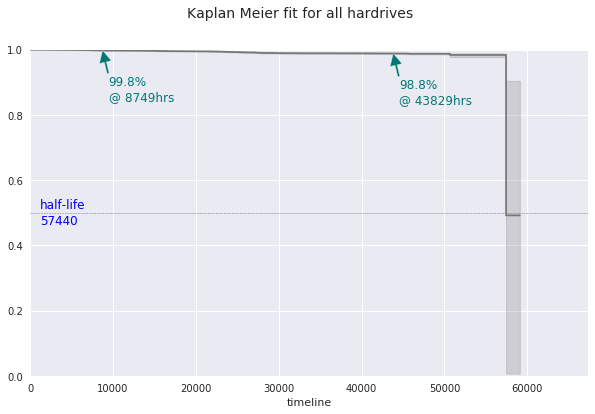

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)

km = sa.KaplanMeierFitter()
km.fit(durations=df['maxhours'], event_observed=df['failed'])
plot_km(km, axes, xmax=df.shape[0], arws=[8760, 43830],
        suptxt='Kaplan Meier fit for all hardrives', smlfs=12)

**Observation**:

- The HDDs survive well throughout most of the study period, but passed ~57500 hours, 50% of the HDDs die.
- At approx 1 year (8,750 hours) of continuous uptime aka 'power-on hours' we see 99.8% of drives remain active. Stated another way, we can expect approx 0.2% of our HDDs to fail during their first year of power-on time.
- At approx 5 years (43,830 hours) we see 98.8% of drives are still running, or another way, after 5 years we can expect 1.2% of our drives to have failure.

### Lifetime by Manufacturer

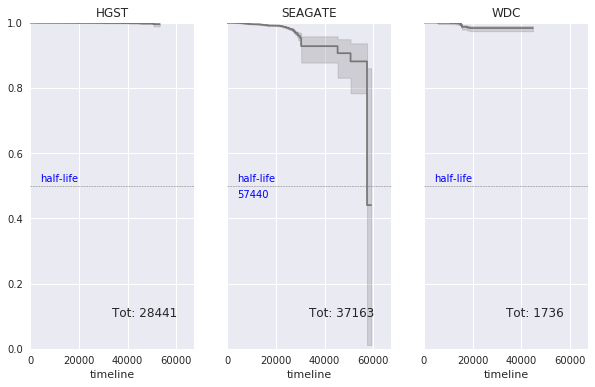

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['manufacturer'].value_counts()), squeeze=False, sharex=True, sharey=True)

for j, mfr in enumerate(np.unique(df['manufacturer'])):
    dfsub = df.loc[df['manufacturer']==mfr]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
    plot_km(km, axes, j=j, subtxt=mfr, xmax=df.shape[0])
    axes[0,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')

**Observe**:

- Here we see again that Seagate drives in general have a much shorter time to failure than HGST and WDC
- We see the large drop around 20,000 hours, after this only 80% remain
- After 5 years of 'power-on' we see only 60% remain
- We also see that Seagate drives have been in usage for a longer time at Backblaze

### Lifetime by Manufacturer by Capacity

Let's add harddrive capacity into the analysis to really try to isolate the poorly performing models

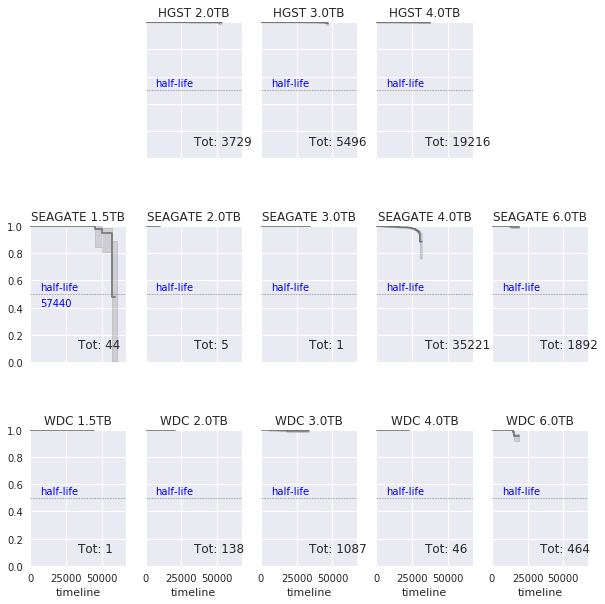

In [21]:
fig, axes = plt.subplots(nrows=len(df['manufacturer'].value_counts()),
                         ncols=len(df['capacity'].value_counts()),
                         squeeze=False, sharex=True, sharey=True, figsize=(10,10))

for i, mfr in enumerate(np.unique(df['manufacturer'])):
    for j, cap in enumerate(np.unique(df['capacity'])):
        dfsub = df.loc[(df['manufacturer']==mfr) & (df['capacity']==cap)]
        if dfsub.shape[0]!=0:
            km = sa.KaplanMeierFitter()
            km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
            plot_km(km, axes, i=i, j=j, subtxt='{} {}'.format(mfr, cap), xmax=df.shape[0])
            axes[i,j].annotate('Tot: {}'.format(dfsub.shape[0]), xy=(0.5,0.1), xycoords='axes fraction')
        else:
            axes[i,j].axis('off')

**Observe:**

- 1.5TB drives have been in longest use at BackBlaze, which makes sense since they're older products.
- After 5 years approx 20% of Seagate drives have failed
- Only 4 drives from WDC are this size, but they perform well and appear not to fail.
- 4TB & 6TB drives appear to be quite resilient throughout all manufacturers
- 2TB & 3TB drives show many issues, particularly Seagate drives, which have a measured half-life around 37k & 23k hours respectively (4.2 years & 2.6 years)

***Let's focus on 3TB harddrives for a minute:***

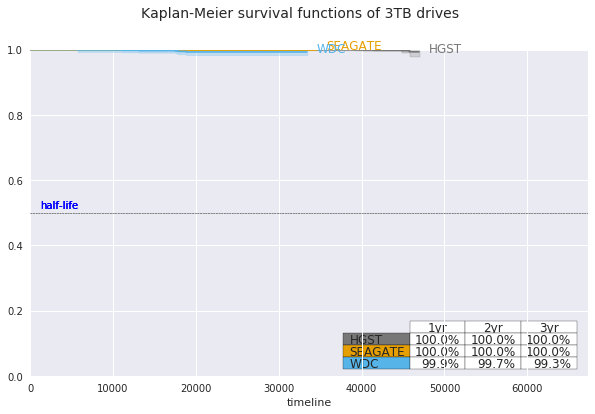

In [22]:
dd = OrderedDict()
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, sharex=True, sharey=True)
fig.suptitle('Kaplan-Meier survival functions of 3TB drives', fontsize=14)

for j, mfr in enumerate(np.unique(df['manufacturer'])):
    dd[mfr] = {8760:'', 17520:'', 26280:''}
    dfsub = df.loc[(df['manufacturer']==mfr) & (df['capacity']=='3.0TB')]
    km = sa.KaplanMeierFitter()
    km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
    ax = km.plot(ax=axes[0,0], legend=False)
    axes[0,0].axhline(0.5, ls='--', lw=0.5)
    axes[0,0].annotate('half-life', xy=(0,0.5), xycoords='axes fraction'
                ,xytext=(10,4), textcoords='offset points', color='b', fontsize=10)
    fnlS = km.survival_function_.iloc[-1:,:]
    axes[0,0].annotate('{}'.format(mfr), xy=(fnlS.index.values[0],fnlS.values[0][0])
                       ,xycoords='data', color=cmap_clrbld[j], fontsize=12
                       ,xytext=(10,0), textcoords='offset points')
    for pt in dd[mfr].keys():
        tml = km.survival_function_[:int(pt)].tail(1)
        dd[mfr][pt] = tml.values[0][0]

    ax.set_ylim([0,1])
    ax.set_xlim([0,df.shape[0]])

tbl = plt.table(cellText=pd.DataFrame(dd).T.applymap(lambda x: '{:.1%}'.format(x)).as_matrix(),
                loc=('lower right'), colWidths=[0.1]*3,
                rowLabels=pd.DataFrame(dd).T.index, colLabels=['1yr','2yr','3yr'],
                rowColours=cmap_clrbld[:3])

**Observe:**

- HGST 3TB drives appear to have far fewer failures than the rest - thoughout the whole study
- At the 1 year mark, WDC drives perform the worst, with 3.6% of drives experiencing failure
- However at the 2 year mark, Seagate drives have begun to nosedive, with 15% failure
- At the 3 yr mark only 58% of Seagate 3TB drives have failed, whereas only 2% of HGST have failed.

## Observations from Kaplan-Meier modelling notebook:

- Overall, the population of harddrives show very low failure rates (long durations for time-to-event), with approx 1.4% failure after 1 year of power-on, 23% failure after 5 years of power-on.
- When separating the dataset by manufacturer, we see overall that Seagate drives demonstrate a far larger failure rate than HGST and WGST: approx 40% failure at 5 years of power-on.
- When separating by capacity too, we see a much clearer picture:
    + The high failure rate for Seagate seems to be mainly in their 2TB and 3TB drives, with the latter having a measured halflife of approx. 23,000 hours or 2.6 years.
    + As discussed in the Notebook, most of this dataset has such few failures that we don't see a measured halflife, so it's comparatively unusual to measure a halflife at all for the Seagate drives
    + The Seagate drives fare better in the 4TB and 6TB capacities, and show similar good survival with HGST and WDC.
- When we isolate to the 3TB drives the comparison between drive failures becomes especially clear:
    + Seagate starts out as well as the others, with 1.3% failure at 1 year, actually faring 3x better than WDC's 3.6% failure
    + The Seagate drives then begin to drop quickly and by the 2 year mark have 15% failure which compares badly to HGST's 0.6% and WDC's 6.4%
    + At the 3 year mark we only have data for HGST and Seagate (WDC drives were not in use for long enough) and the comparison is poor: Seagate has experienced 58.3% failure compared to 1.7% for HGST, roughly a 35:1 ratio of failures.

## Outputs & Capabilities of Kaplan-Meier modelling

As demonstrated, the lifelines package makes it very simple to run a Kaplan-Meier model:

![Code](KM_code.png)
    
... but this is a non-parametric, non-generalising model which simply 'remembers' all the input data to create a survival function. Without a parametric form we can't use the model to predict new, unseen data, and it's hard for us to quantify the relative impact upon survival of a hardrive coming from e.g. Seagate vs HGST, or being e.g. 4TB vs 3TB.